In [8]:
# Run with 'solar': conda
%reset -f
from tsai.all import *

## Problem describing values

In [2]:
num_weeks = 10
num_days_per_week = 7
num_hours_per_day = 24
num_points = num_hours_per_day * num_days_per_week * num_weeks

In [3]:
data = np.zeros((num_points, 4))
X_time = np.linspace(1, num_points, num_points)

Create `numpy` array with four columns.

In [4]:
def create_sample_data(with_unique=False):
    """Fills the array with synthetic (sinusoidal) data."""
    if with_unique:
        data[0::2,0] = 1
        data[1::2,0] = 2
    else:
        data[:,0] = 1
    data[:,1] = 2*np.sin(2*np.pi*X_time/num_days_per_week/num_hours_per_day)
    data[:,2] = 2*np.sin(2*np.pi*X_time/num_days_per_week/num_hours_per_day + 2)
    data[:,3] = data[:,1] + data[:,2] + np.random.randint(-10,10,(num_points))/10
    return data

Create `dataframe` with four columns.

In [5]:
data = create_sample_data()
tmp = pd.DataFrame(data, columns=['unique_id', 'var1', 'var2', 'target'])
tmp.head()

,unique_id,var1,var2,target
0,1.0,0.074782,1.786203,1.960985
1,1.0,0.149460,1.751312,1.300772
2,1.0,0.223929,1.713973,2.337902
3,1.0,0.298085,1.674236,2.572320
4,1.0,0.371823,1.632157,2.703980


In [6]:
df = tmp.reset_index()
df.rename(columns={'index': 'time'}, inplace=True)
df = df.sort_values('time')
df.head()

,time,unique_id,var1,var2,target
0,0,1.0,0.074782,1.786203,1.960985
1,1,1.0,0.149460,1.751312,1.300772
2,2,1.0,0.223929,1.713973,2.337902
3,3,1.0,0.298085,1.674236,2.572320
4,4,1.0,0.371823,1.632157,2.703980


## Slicing batches from data

`SlidingWindow` parameters.

In [7]:
add_padding_feature = False #1 Add an additional feature indicating whether each timestep is padded (1) or not (0).
ascending = True #2 Used in sorting.
check_leakage = True #3 Checks if there's leakage in the output between X and y
copy_=True #4 Copy the original object to avoid changes in it.
get_x = ['var1', 'var2'] #5 Indices of columns that contain the independent variable (xs). If None, all data will be used as x.
get_y = ['target'] #6 Indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created (unlabeled data).
horizon = num_days_per_week*num_hours_per_day #7 Number of future datapoints to predict (y). If get_y == [] horizon will be set to 0.
output_processor = None #8 (Optional) Function to process the final output (X (and y if available)). This is useful when some values need to be removed.
padding = 'pre' #9 (Optional) Pad either before or after each sequence. Defaults: 'pre'. If pad_remainder == False, it indicates the starting point to create the sequence ('pre' from the end, and 'post' from the beginning)
padding_value = np.nan #10 Float that will be used for padding. Default: np.nan.
pad_remainder = False #11 Allows to pad remainder subsequences when the sliding window is applied and get_y == [] (unlabeled data).
return_key = False #12 When True, the key corresponsing to unique_id_cols for each sample is returned
seq_first = True #13 True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len).
sort_by = ['time'] #14 Column/s used for sorting the array in ascending order.
start = 0 #15 Determines the step where the first window is applied. Default: 0. Previous steps will be discarded. 
stride = 1 #16 Number of datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap).
unique_id_cols = []#['unique_id'] #17 pd.DataFrame columns that will be used to identify a time series for each entity.
verbose = True #18 Controls verbosity. True or 1 displays progress bar. 2 or more show records that cannot be created due to its length.
window_len = num_days_per_week*num_hours_per_day #19 Length of lookback.
y_func = None #20 Optional function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!.

Apply `SlidingWindowPanel` on `DataFrame`.

In [8]:
# X, y = SlidingWindowPanel(
#                           add_padding_feature=add_padding_feature,
#                           ascending=ascending,
#                           check_leakage=check_leakage,
#                           copy=copy_,
#                           get_x=get_x,
#                           get_y=get_y,
#                           horizon=horizon,
#                           #output_processor=output_processor,
#                           padding=padding,
#                           padding_value=padding_value,
#                           pad_remainder=pad_remainder,
#                           return_key=return_key,
#                           seq_first=seq_first,
#                           sort_by=sort_by,
#                           start=start,
#                           stride=stride,
#                           unique_id_cols=unique_id_cols,
#                           verbose=verbose,
#                           window_len=window_len,
#                           y_func=y_func,
#                           )(df)

Faster way to apply `SlidingWindow` (on `ndarray`, `Tensor` or `DataFrame`)

In [9]:
output = [df.groupby(['unique_id']).apply(lambda x: SlidingWindow(
    add_padding_feature=add_padding_feature,
    ascending=ascending,
    check_leakage=check_leakage,
    copy=copy_, # it's important to set copy to True when used in this way!!!
    get_x=get_x,
    get_y=get_y,
    horizon=horizon,
    #output_processor=output_processor,
    padding=padding,
    padding_value=padding_value,
    pad_remainder=pad_remainder,
    #return_key=return_key, {unexpected keyword}
    seq_first=seq_first,
    sort_by=sort_by,
    start=start,
    stride=stride,
    #unique_id_cols=unique_id_cols, {unexpected keyword}
    #verbose=verbose, {unexpected keyword}
    window_len=window_len,
    y_func=y_func,
)(x))][0].values

X2 = np.concatenate([oi[0] for oi in output])
y2 = np.concatenate([oi[1] for oi in output])

(?, len(get_x), window_len) (?, horizon)

In [10]:
#print(type(X), type(y))
#print(X.shape, y.shape)
print(type(X2), type(y2))
print(X2.shape, y2.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1345, 2, 168) (1345, 168)


In [11]:
def plot_batches(X, y):
    """Plots the created batches."""
    lim = 10
    half_lim = int(lim/2)
    num = X.shape[0]
    feat = X.shape[1]
    if num > lim:
        print(f"Too many batches. Display only the first and last {half_lim}.")
        num = lim
    fig, axs = subplots(1, num)
    for c,n in enumerate(range(half_lim)):
        for f in range(feat):
            axs[c].plot(X[n,f,:])#, 'tab:green')
        axs[c].plot(y[n])#, 'tab:red')
        axs[c].grid()
    for c,n in enumerate(range(int(X.shape[0]-half_lim-1), X.shape[0]-1)):
        for f in range(feat):
            axs[c + half_lim].plot(X[n,f,:])#, 'tab:green')
        axs[c + half_lim].plot(y[n])#, 'tab:red')
        axs[c + half_lim].grid()

In [12]:
#plot_batches(X, y)

### Raw learning data before slicing
Shown are `num_weeks` cycles

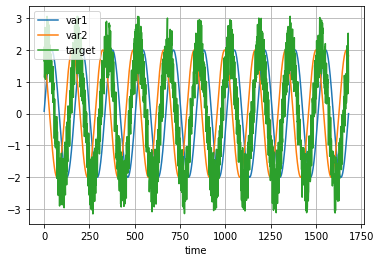

In [14]:
df.plot(x='time', y=['var1', 'var2', 'target'], grid=True);

### Weekly example batches for learning
They are shifted by one hour. Weather input (yellow and blue). Power output (green)

Too many batches. Display only the first and last 5.


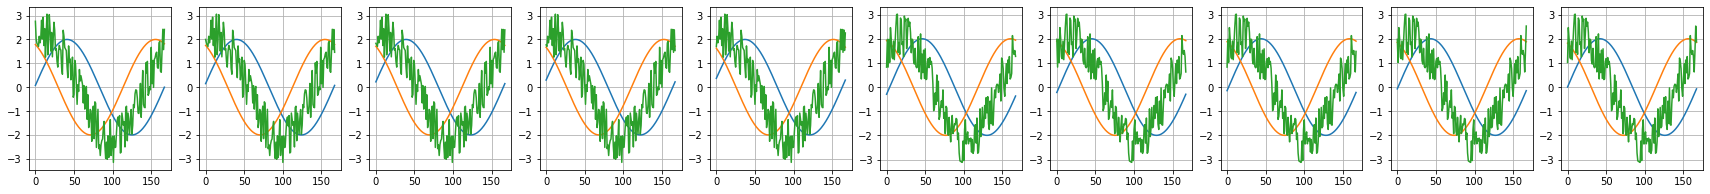

In [13]:
plot_batches(X2, y2)

### Split batches into training and validation set

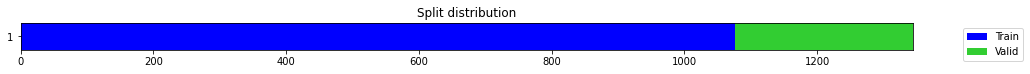

((#1076) [0,1,2,3,4,5,6,7,8,9...],
 (#269) [1076,1077,1078,1079,1080,1081,1082,1083,1084,1085...])

In [15]:
splits = get_splits(o=y2, n_splits=1, valid_size=.2, shuffle=False)
splits

## Dataloader

In [22]:
dls = get_ts_dls(X=X2, y=y2, splits=splits)

## Learner with specific callbacks

In [17]:
cbs = [ShowGraph(), SaveModelCallback(monitor='valid_loss', comp=np.less, min_delta=0.01), EarlyStoppingCallback(monitor='valid_loss', comp=np.greater, min_delta=0.01, patience=10)]
learn = ts_learner(dls, InceptionTimePlus, cbs=cbs, loss_func=mae, metrics=[mae, mse])

### Find the best learning rate

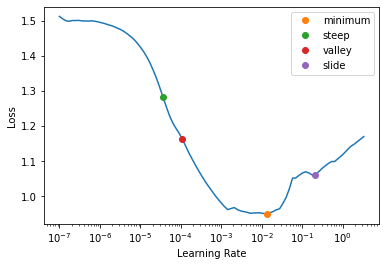

In [18]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

### Train model with found learning rate

epoch,train_loss,valid_loss,mae,mse,time
0,1.280270,1.290168,1.290168,2.263628,00:15
1,1.035861,0.976168,0.976168,1.389273,00:13
2,0.839006,0.559825,0.559825,0.451716,00:16
3,0.732765,0.541259,0.541259,0.411963,00:14
4,0.663073,0.530497,0.530497,0.390896,00:13
5,0.616546,0.521834,0.521834,0.373710,00:13
6,0.584743,0.520145,0.520145,0.370470,00:13
7,0.563335,0.520695,0.520695,0.371171,00:12
8,0.549043,0.523624,0.523624,0.375929,00:13
9,0.539640,0.526932,0.526932,0.382749,00:12


Better model found at epoch 0 with valid_loss value: 1.2901684045791626.


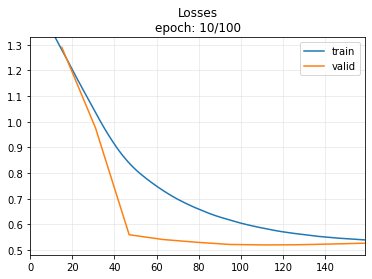

Better model found at epoch 1 with valid_loss value: 0.9761675000190735.
Better model found at epoch 2 with valid_loss value: 0.5598254799842834.
Better model found at epoch 3 with valid_loss value: 0.5412585735321045.
Better model found at epoch 4 with valid_loss value: 0.5304967164993286.
Better model found at epoch 6 with valid_loss value: 0.5201446413993835.
No improvement since epoch 0: early stopping


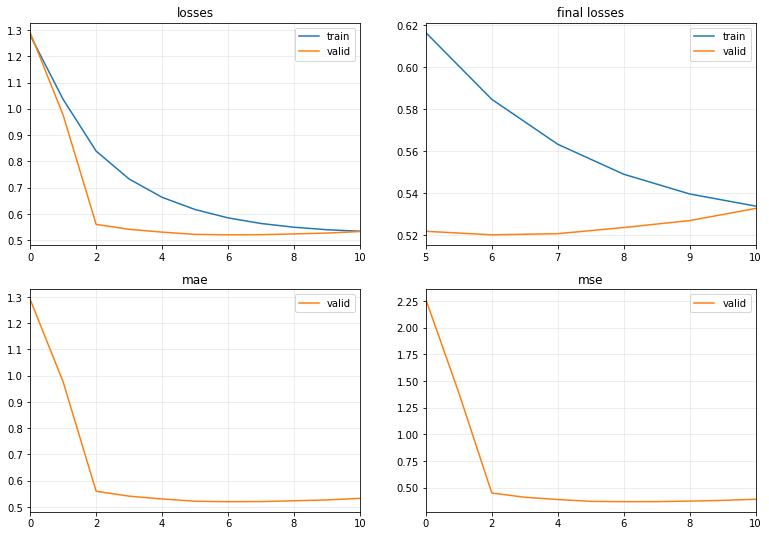

In [19]:
learn.fit_one_cycle(100, lr_max=lrs.valley)

In [20]:
probas, _, preds = learn.get_X_preds(X2[splits[1]])
probas.shape, preds.shape

(torch.Size([269, 168]), torch.Size([269, 168]))

## Inference with validation split
`i` picks one validation batch

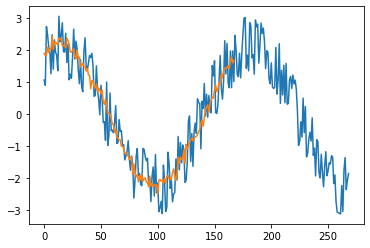

In [21]:
i = 100
plt.plot(y2[splits[1],i])
plt.plot(preds[i,:])
plt.show()